# Sử dụng 1 bộ dữ liệu time-series bất kì (1 biến hoặc nhiều biến). 
tại link (https://github.com/thieu1995/csv-files/).

Chọn một model regression bất kì trên scikit-learn (https://scikit-learn.org/stable/search.html?q=regression)

Áp dụng các kĩ thuật trên lớp vào bộ dữ liệu time-series trên.

    Scaling, (1 điểm)

    Building, (1 điểm)

    Hyper-parameter tuning, (2 điểm)

    Pipeline, (1 điểm)

    GridsearchCV, (1 điểm)

    Forecasting, (1 điểm)

    Calculate Metrics ví dụ như RMSE, MSE, MAE, MAPE (2 điểm)

    Vẽ đồ thị giá trị thực tế và dự đoán (1 điểm)


In [27]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns             # statistical data visualization
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})


In [28]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [29]:
path = "../week10_timeseries/AirPassengers.csv"

# data = pd.read_csv(path, sep = ",")
# data = pd.DataFrame(data)
# data.head()
def get_df():
    df = pd.read_csv(path)
    df.head()
    df.columns = ['date','#passengers']
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    return df

df = get_df()
df.head(10)

,date,#passengers,year,month
0,1949-01-01,112,1949,1
1,1949-02-01,118,1949,2
2,1949-03-01,132,1949,3
3,1949-04-01,129,1949,4
4,1949-05-01,121,1949,5
5,1949-06-01,135,1949,6
6,1949-07-01,148,1949,7
7,1949-08-01,148,1949,8
8,1949-09-01,136,1949,9
9,1949-10-01,119,1949,10


In [30]:
# First Order Differencing
df = get_df()
ts_diff = np.diff(df['#passengers'])
df['#passengers_diff1'] = np.append([0], ts_diff)
dataset = pd.DataFrame(df['#passengers'])

In [31]:
data = series_to_supervised(dataset, n_in=3, n_out=1)
print(data)

     var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
3        112.0      118.0      132.0      129
4        118.0      132.0      129.0      121
5        132.0      129.0      121.0      135
6        129.0      121.0      135.0      148
7        121.0      135.0      148.0      148
..         ...        ...        ...      ...
139      472.0      535.0      622.0      606
140      535.0      622.0      606.0      508
141      622.0      606.0      508.0      461
142      606.0      508.0      461.0      390
143      508.0      461.0      390.0      432

[141 rows x 4 columns]


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def draw_true_predict(y_true, y_pred):
    size = len(y_true)
    plt.plot(list(range(size)), y_true, label='real', color='blue')
    plt.plot(list(range(size)), y_pred, label='predicted', color='red')
    plt.legend(loc='best')
    plt.title('Real vs Predicted values')
    plt.show()

def calculate_metrics(y_true, y_pred):
    # Calculate metrics
    MSE = mean_squared_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    print(f"MSE: {MSE}, MAPE: {MAPE}, R2: {R2}")

# RF

     var1(t-3)  var1(t-2)  var1(t-1)
3        112.0      118.0      132.0
4        118.0      132.0      129.0
5        132.0      129.0      121.0
6        129.0      121.0      135.0
7        121.0      135.0      148.0
..         ...        ...        ...
139      472.0      535.0      622.0
140      535.0      622.0      606.0
141      622.0      606.0      508.0
142      606.0      508.0      461.0
143      508.0      461.0      390.0

[141 rows x 3 columns] 3      129
4      121
5      135
6      148
7      148
      ... 
139    606
140    508
141    461
142    390
143    432
Name: var1(t), Length: 141, dtype: int64
MSE: 6279.126227586205, MAPE: 0.12383127761884719, R2: -0.02860785055969428


/tmp/ipykernel_7772/1610778839.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train_scaled, Y_train_scaled)


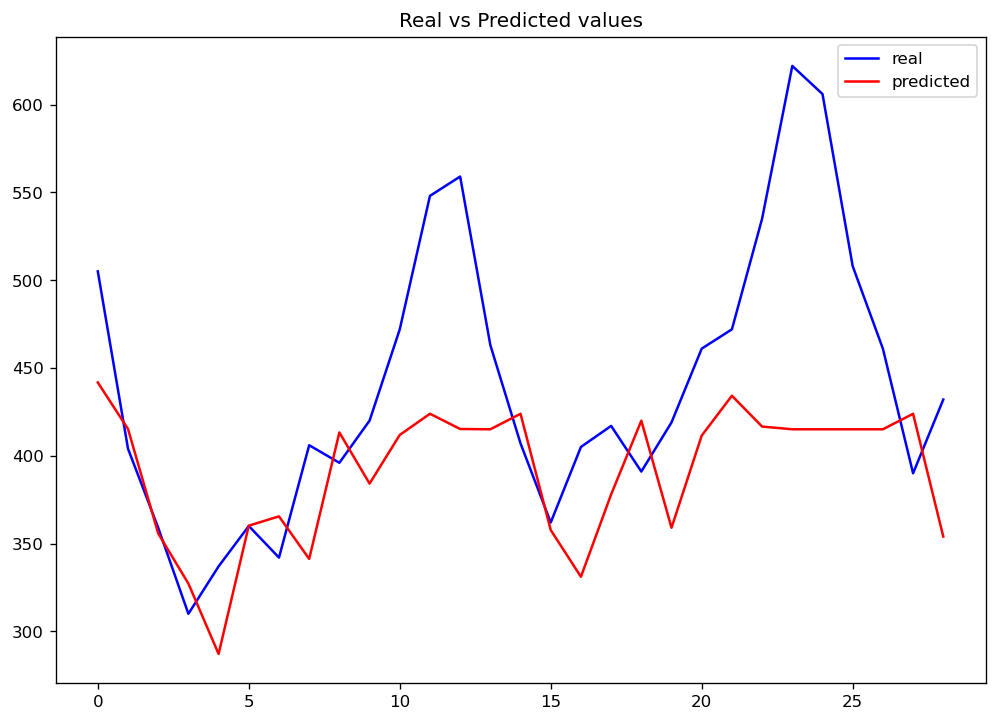

In [33]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X, Y = data[['var1(t-3)', 'var1(t-2)', 'var1(t-1)']], data['var1(t)']
print(X, Y)
X = X.values
Y = Y.values

# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=0)
Y_train = np.reshape(Y_train, (-1, 1))
Y_test = np.reshape(Y_test, (-1, 1))

scaler_feature = StandardScaler()
scaler_feature.fit(X_train)
X_train_scaled = scaler_feature.transform(X_train)
X_test_scaled = scaler_feature.transform(X_test)

scaler_label = StandardScaler()
scaler_label.fit(Y_train)
Y_train_scaled = scaler_label.transform(Y_train)
Y_test_scaled = scaler_label.transform(Y_test)


# Initialize the estimator
estimator = RandomForestRegressor()

# Fit the data
estimator.fit(X_train_scaled, Y_train_scaled)

# Make predictions
y_pred = estimator.predict(X_test_scaled)
y_pred_unscaled = scaler_label.inverse_transform(np.reshape(y_pred, (-1, 1)))

# Calculate metrics
calculate_metrics(Y_test, y_pred_unscaled)

draw_true_predict(Y_test, y_pred_unscaled)

# SVR

MSE: 0.9104991639727621, MAPE: 0.47183671350054246, R2: -1.0942261591776563


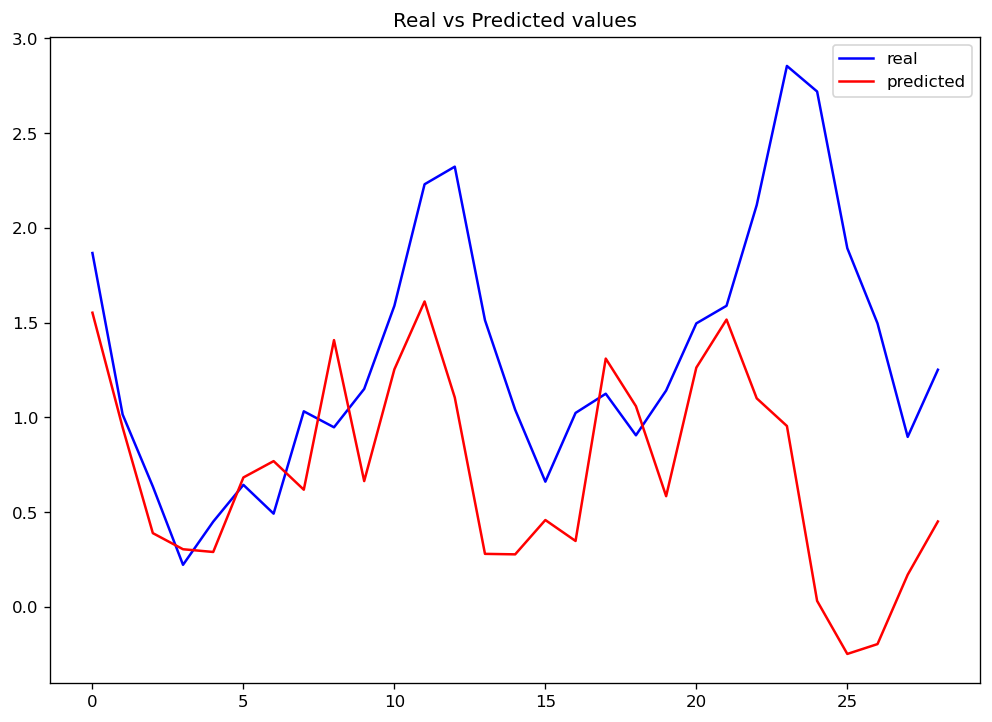

In [34]:
from sklearn.preprocessing import scale
from sklearn.svm import SVR

x = scale(X)
y = scale(Y)

# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=0)

# Initialize the estimator
estimator = rfr = SVR(C=10, epsilon=0.1)

# Fit the data
estimator.fit(X_train, Y_train)

# Make predictions
pred = estimator.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..C=0.1, epsilon=0.1, kernel=rbf;, score=-16.565 total time=   0.0s
[CV 2/5] END ...C=0.1, epsilon=0.1, kernel=rbf;, score=-0.141 total time=   0.0s
[CV 3/5] END ...C=0.1, epsilon=0.1, kernel=rbf;, score=-0.247 total time=   0.0s
[CV 4/5] END ....C=0.1, epsilon=0.1, kernel=rbf;, score=0.517 total time=   0.0s
[CV 5/5] END ...C=0.1, epsilon=0.1, kernel=rbf;, score=-2.305 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.1, kernel=linear;, score=-0.623 total time=   0.0s
[CV 2/5] END .C=0.1, epsilon=0.1, kernel=linear;, score=0.286 total time=   0.0s
[CV 3/5] END .C=0.1, epsilon=0.1, kernel=linear;, score=0.287 total time=   0.0s
[CV 4/5] END .C=0.1, epsilon=0.1, kernel=linear;, score=0.611 total time=   0.0s


[CV 5/5] END .C=0.1, epsilon=0.1, kernel=linear;, score=0.341 total time=   0.0s
[CV 1/5] END .C=0.1, epsilon=0.1, kernel=poly;, score=-18.026 total time=   0.0s
[CV 2/5] END ..C=0.1, epsilon=0.1, kernel=poly;, score=-5.170 total time=   0.0s
[CV 3/5] END ..C=0.1, epsilon=0.1, kernel=poly;, score=-0.745 total time=   0.0s
[CV 4/5] END ..C=0.1, epsilon=0.1, kernel=poly;, score=-0.791 total time=   0.0s
[CV 5/5] END ..C=0.1, epsilon=0.1, kernel=poly;, score=-1.454 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.1, kernel=sigmoid;, score=-49.259 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.1, kernel=sigmoid;, score=-1.019 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.1, kernel=sigmoid;, score=-3.322 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.1, kernel=sigmoid;, score=-0.832 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.1, kernel=sigmoid;, score=-1.591 total time=   0.0s
[CV 1/5] END ..C=0.1, epsilon=0.2, kernel=rbf;, score=-23.006 total time=   0.0s
[CV 2/5] END ...C=0.1,

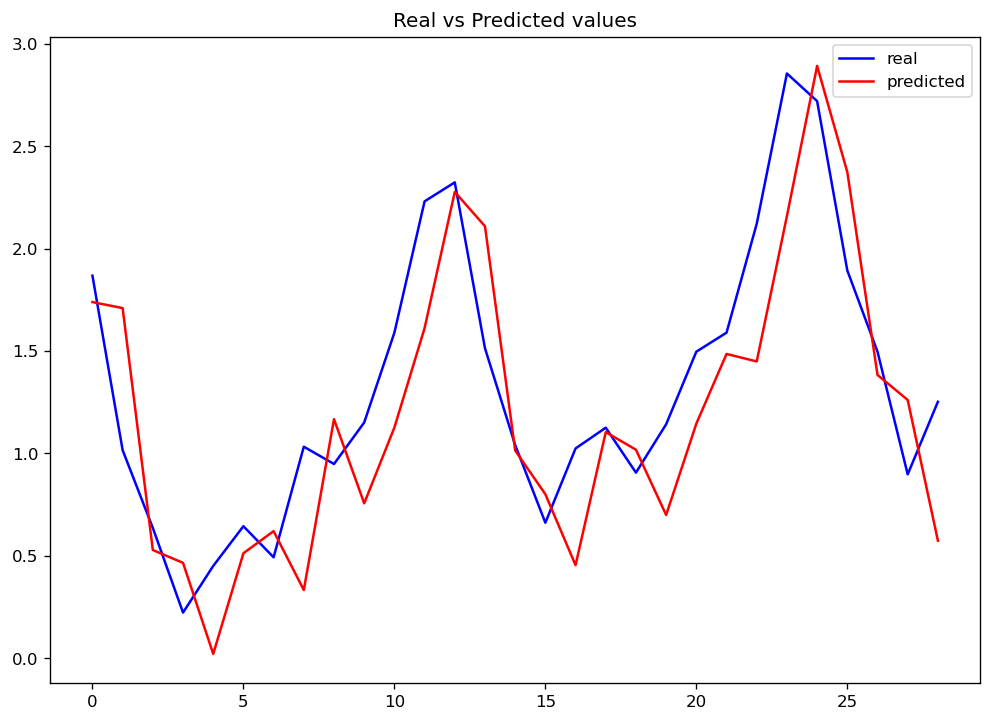

In [35]:
## Hyper-parameter tuning using GridSearchCV

from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

x = scale(X)
y = scale(Y)

# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=0)

# defining parameter range
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.1, 0.2, 0.3, 0.5, 1.0],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# defining the gridsearchCV object
grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=3)

# Fit the data
grid.fit(X_train, Y_train)

# Make predictions
pred = grid.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=rbf;, score=-16.579 total time=   0.0s
[CV 2/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=rbf;, score=-0.152 total time=   0.0s
[CV 3/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=rbf;, score=-0.265 total time=   0.0s
[CV 4/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=rbf;, score=0.516 total time=   0.0s
[CV 5/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=rbf;, score=-2.322 total time=   0.0s
[CV 1/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=linear;, score=-0.254 total time=   0.0s
[CV 2/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=linear;, score=0.322 total time=   0.0s
[CV 3/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=linear;, score=0.308 total time=   0.0s
[CV 4/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=linear;, score=0.642 total time=   0.0s
[CV 5/5] END SVR__C=0.1, SVR__epsilon=0.1, SVR__kernel=linear;, score=0.481 total time=   0

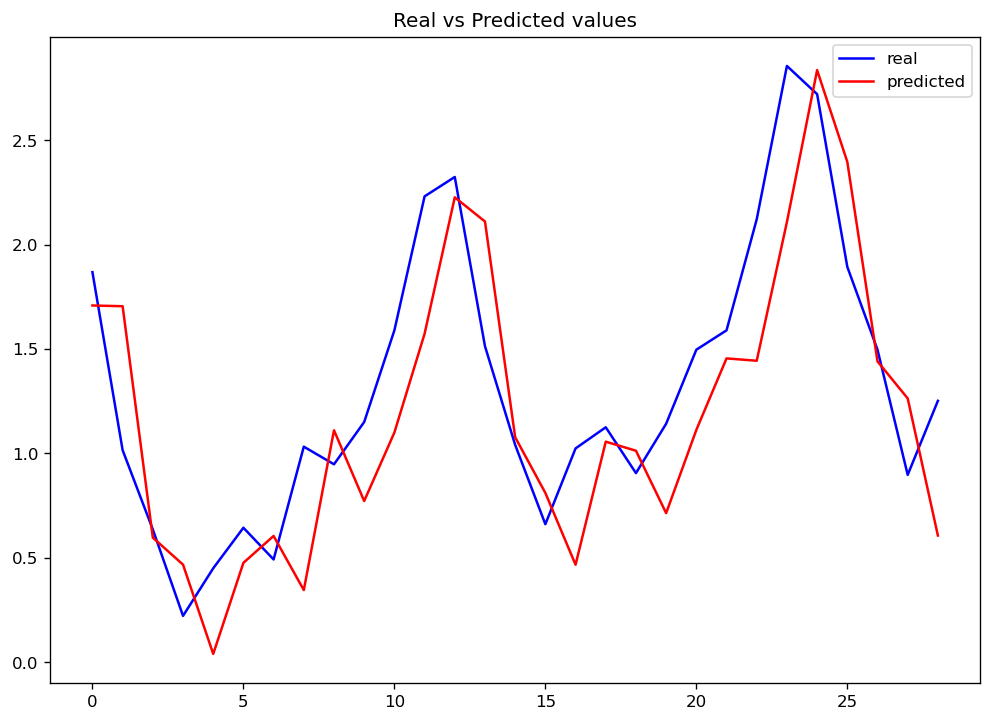

In [36]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV


#++++++++++++++++++++++++++++++++++++
#+ create train and test sets
#++++++++++++++++++++++++++++++++++++
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=0)


#++++++++++++++++++++++++++++++++
# create the pipeline object
#++++++++++++++++++++++++++++++++
steps = [('scaler', StandardScaler()), ('SVR', SVR())]
pipeline = Pipeline(steps)


#++++++++++++++++++++++++++++++++++++++
#+ create the hyperparameter space
#++++++++++++++++++++++++++++++++++++++
parameteres = {
    'SVR__C': [0.1, 1, 10, 100, 1000],
    'SVR__epsilon': [0.1, 0.2, 0.3, 0.5, 1.0],
    'SVR__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

#++++++++++++++++++++++++++++++
#+ Grid Search Cross Validation
#++++++++++++++++++++++++++++++
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5, verbose=3)

# Fit the data
grid.fit(X_train, Y_train)

# get the best parameters
print(grid.best_params_)

# Make predictions
pred = grid.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)